following the https://blog.tensorflow.org/2019/09/disaster-watch-crisis-mapping-platform.html method

In [1]:
# Mounting drive to have access to training resources

from google.colab import drive

drive.mount('/content/drive/')
resource_path = '/content/drive/My Drive/GuidoApp/NLP/disaster_tweet_recognition/resources/Datasets'

Mounted at /content/drive/


In [2]:

%%capture
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.base import TransformerMixin ,BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential ,model_from_json
from tensorflow.keras.layers import Embedding,Dense,Dropout ,GlobalMaxPool1D, Conv1D

from IPython.display import clear_output
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


import tqdm

In [3]:
COMBINDED_DATASET='combined.csv'
DATA_DIRECTORY='/content/drive/My Drive/GuidoApp/NLP/disaster_tweet_recognition/resources'
class DatasetExtractor(BaseEstimator,TransformerMixin):
    """Extractor class that loads multiple Tweet files and creates a single unified file."""
    
    def transform(self,X,y=None):
        return self.hot_load()
    
    def hot_load(self):
        """Loads the pre-combined file if exists otherwise load all the files"""
        combined_file_path=f'{DATA_DIRECTORY}/{COMBINDED_DATASET}'
        if os.path.isfile(combined_file_path):
            print('File Exists.Reloaded.')
            return pd.read_csv(combined_file_path, index_col=0)
        print('Loading Files..')
        combined_dataset=self.load_data()
        combined_dataset.to_csv(combined_file_path)
        return combined_dataset
    
    def load_data(self):
        """Loads multiple disaster related tweet file and returns a Single Pandas data frame"""    
        combined_dataset=pd.DataFrame()
        for file_name in os.listdir(path=DATA_DIRECTORY):
            category=self.extract_category_name(file_name)
            df=pd.read_csv(f'{DATA_DIRECTORY}/{file_name}')
            df['category']= category    
            combined_dataset=combined_dataset.append(df,ignore_index = True)
        return  combined_dataset  
    
    def extract_category_name(self,file_name):
        """Helper method that extracts the Disaster Category from the file name"""
        category=file_name.split('.')[0]
        if '_' in category:
            category=category.split('_')[0]
        return category

In [4]:
dataset=DatasetExtractor().transform(None)
dataset.head()

File Exists.Reloaded.


,tweet id,tweet,label,category
0,'348351442404376578',@Jay1972Jay Nope. Mid 80's. It's off Metallica...,off-topic,floods
1,'348167215536803841',Nothing like a :16 second downpour to give us ...,off-topic,floods
2,'348644655786778624',@NelsonTagoona so glad that you missed the flo...,on-topic,floods
3,'350519668815036416',"Party hard , suns down , still warm , lovin li...",off-topic,floods
4,'351446519733432320',@Exclusionzone if you compare yourself to wate...,off-topic,floods


In [5]:
STOP_WORDS=["Boston", "Oklahoma","Texas","Nepal","California","Calgary","Chile","Alberta","Pakistan" ,"WestTX","Canada","yycflood","USA","'S",]
class DatasetCleaner(BaseEstimator,TransformerMixin):
    """Removes Redundent features and rows with missing values"""
    def transform(self,X,y=None):
        columns=X.columns.tolist()
        X.columns=[column.strip() for column in columns]
        X=X.drop('tweet id',axis=1)
        X=X.dropna()
        X['tweet']=X['tweet'].str.replace('@', '')
        X['tweet']=X['tweet'].str.replace('#', '')
        #X['tweet']=X['tweet'].str.replace('.', '')
        #X['tweet']=X['tweet'].str.replace(',', '')
        X['tweet']=X['tweet'].str.replace('http\S+', '',regex=True)
        X['tweet']=X['tweet'].str.replace('@\w+', '',regex=True)
        #X['tweet']=X['tweet'].str.replace('\s+', '',regex=True)  # space in string
        X['tweet']=X['tweet'].str.strip()
        X['tweet']=X['tweet'].str.lower()
        for word in STOP_WORDS:
            word=word.lower()
            X['tweet']=X['tweet'].str.replace(word, '') 
        return X

In [6]:
dataset_cleaned=DatasetCleaner().transform(dataset)
dataset_cleaned.head()

,tweet,label,category
0,jay1972jay nope. mid 80. it off metallica 2nd ...,off-topic,floods
1,nothing like a :16 second downpour to give us ...,off-topic,floods
2,nelsontagoona so glad that you missed the floo...,on-topic,floods
3,"party hard , suns down , still warm , lovin li...",off-topic,floods
4,exclusionzone if you compare yourself to water...,off-topic,floods


In [7]:
Crisis=pd.DataFrame(dataset_cleaned['category'].value_counts())
Crisis.reset_index(inplace=True)
Crisis.rename(columns={'index':'Crisis',"category":'Tweet Count'} ,inplace=True)
Crisis

,Crisis,Tweet Count
0,floods,20064
1,bombing,10012
2,hurricane,10008
3,explosion,10006
4,tornado,9992
5,earthquake,9057


Text(0.5, 0, ' ')

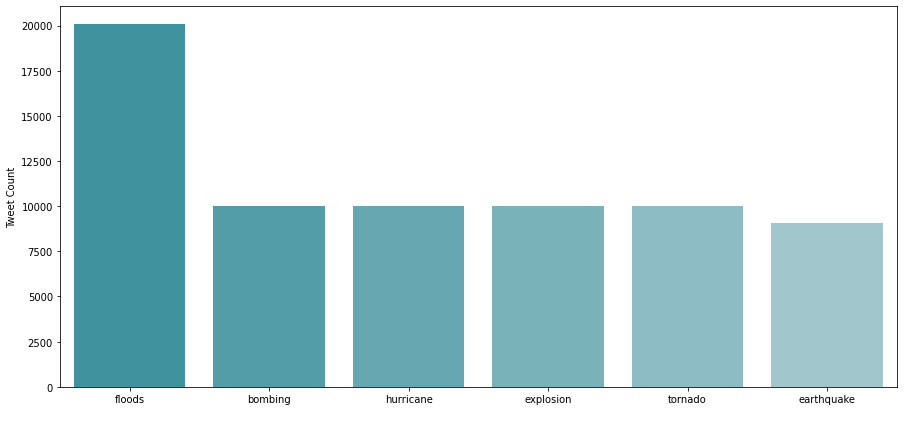

In [8]:
f,ax =plt.subplots(figsize=(15,7))
sns.barplot(x='Crisis',y='Tweet Count',data=Crisis ,palette=sns.light_palette((210, 90, 60),10, input="husl" ,reverse=True),ax=ax)
ax.set_xlabel(' ')

In [9]:
dataset_cleaned['label_full']=dataset_cleaned['label']+'_'+dataset_cleaned['category']
Crisis_topics=pd.DataFrame(dataset_cleaned['label_full'].value_counts())
Crisis_topics.drop('On-topic_earthquake',axis=0,inplace=True)
Crisis_topics.reset_index(inplace=True)
Crisis_topics.rename(columns={'index':'Crisis',"label_full":'Tweet Count'} ,inplace=True)

Crisis_topics

,Crisis,Tweet Count
0,on-topic_floods,10603
1,off-topic_floods,9461
2,on-topic_hurricane,6138
3,on-topic_bombing,5648
4,on-topic_explosion,5246
5,off-topic_tornado,5165
6,on-topic_tornado,4827
7,off-topic_explosion,4760
8,on-topic_earthquake,4580
9,Off-topic_earthquake,4475


Text(0.5, 1.0, 'Numer of on-topic and off-topic Tweets in each crisis Category ')

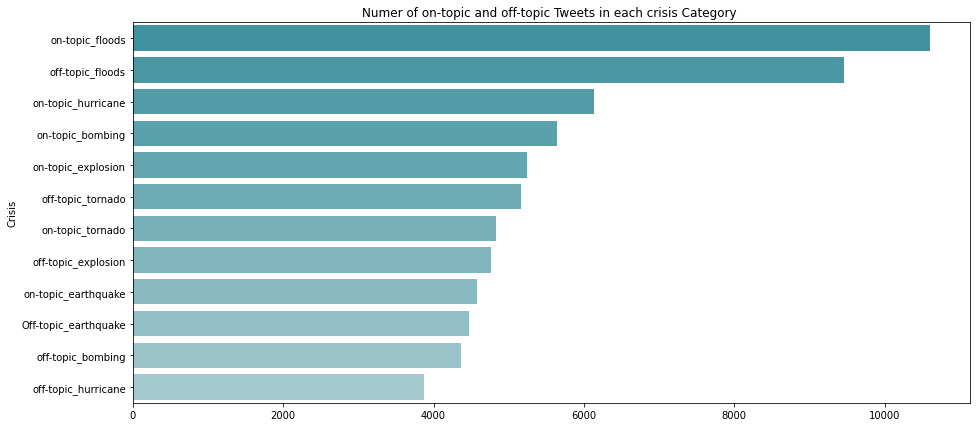

In [10]:
f,ax =plt.subplots(figsize=(15,7))
sns.barplot(y='Crisis',x='Tweet Count',data=Crisis_topics ,palette=sns.light_palette((210, 90, 60),20, input="husl" ,reverse=True),ax=ax)
ax.set_xlabel(' ')
ax.set_title('Numer of on-topic and off-topic Tweets in each crisis Category ')

In [11]:
Crisis_topics_on_topic= Crisis_topics[Crisis_topics['Crisis'].str.contains("on-topic")]
Crisis_topics_on_topic['Tweet_pct']=Crisis_topics_on_topic['Tweet Count']*100/Crisis_topics_on_topic['Tweet Count'].sum()
Crisis_topics_on_topic

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Crisis,Tweet Count,Tweet_pct
0,on-topic_floods,10603,28.624264
2,on-topic_hurricane,6138,16.570380
3,on-topic_bombing,5648,15.247557
4,on-topic_explosion,5246,14.162302
6,on-topic_tornado,4827,13.031154
8,on-topic_earthquake,4580,12.364343


Text(0, 0.5, 'Percentage of on-topic Tweets in Each Category')

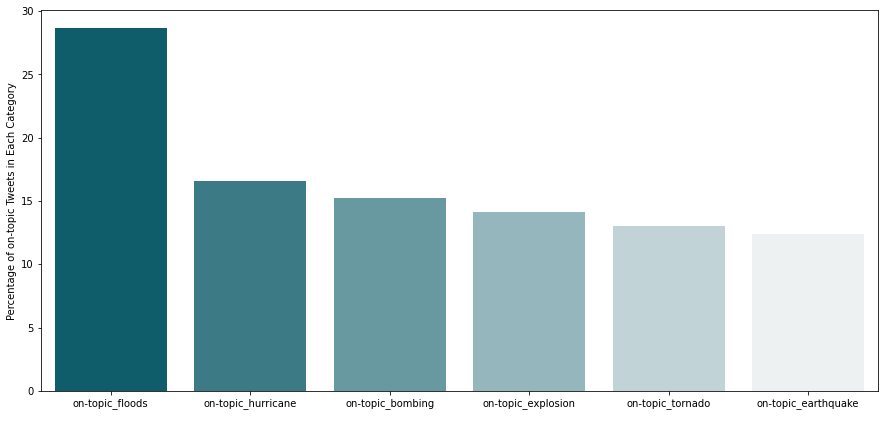

In [12]:

f,ax =plt.subplots(figsize=(15,7))
sns.barplot(x='Crisis',y='Tweet_pct',data=Crisis_topics_on_topic ,palette=sns.light_palette((216, 100, 40), input="husl" ,reverse=True),ax=ax)
ax.set_xlabel(' ')
ax.set_ylabel('Percentage of on-topic Tweets in Each Category')

In [13]:
Crisis_topics_off_topic= Crisis_topics[~Crisis_topics['Crisis'].str.contains("on-topic")]
total_off_topic_tweets=Crisis_topics_off_topic['Tweet Count'].sum()
print("Total Number of 'Off-Topic' Tweets",total_off_topic_tweets)
Crisis_topics_off_topic.head()

Total Number of 'Off-Topic' Tweets 32095


,Crisis,Tweet Count
1,off-topic_floods,9461
5,off-topic_tornado,5165
7,off-topic_explosion,4760
9,Off-topic_earthquake,4475
10,off-topic_bombing,4364


In [14]:
Crisis_topics_off_topic['Crisis']='unrelated'
Crisis_topics_off_topic_g=Crisis_topics_off_topic.groupby(by='Crisis').sum()
Crisis_topics_off_topic_g.reset_index(inplace=True)
all_topics =Crisis_topics_off_topic_g.append(Crisis_topics_on_topic[['Crisis','Tweet Count']])
all_topics

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Crisis,Tweet Count
0,unrelated,32095
0,on-topic_floods,10603
2,on-topic_hurricane,6138
3,on-topic_bombing,5648
4,on-topic_explosion,5246
6,on-topic_tornado,4827
8,on-topic_earthquake,4580


Text(0.5, 1.0, 'Imbalanced Dataset: Total Number of Tweets in each category')

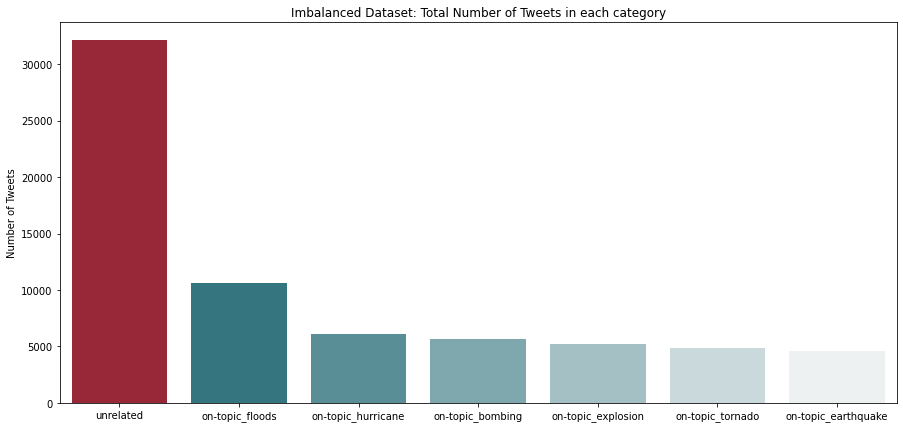

In [15]:
f,ax =plt.subplots(figsize=(15,7))
blues=sns.light_palette((216, 100, 40),all_topics.shape[0], input="husl" ,reverse=True)
blues[0]=sns.color_palette("RdBu", 10)[0]
sns.barplot(x='Crisis',y='Tweet Count',data=all_topics ,palette=blues, ax=ax)
ax.set_xlabel(' ')
ax.set_ylabel('Number of Tweets')
ax.set_title( 'Imbalanced Dataset: Total Number of Tweets in each category')



---



---



---

Data Augmentation for the categories that have less data (all but the flood category
)

In [16]:
#nlp augmentation library
!pip install nlpaug

     |████████████████████████████████| 378kB 2.6MB/s 


In [17]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

In [18]:
def augment_text(df,samples=300,pr=0.2):
    aug_w2v.aug_p=pr
    new_text=[]
    
    ##selecting the minority class samples
    df_n=df[df.target==1].reset_index(drop=True)

    ## data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_n),samples)):
        
            text = df_n.iloc[i]['text']
            augmented_text = aug_w2v.augment(text)
            new_text.append(augmented_text)
    
    
    ## dataframe
    new=pd.DataFrame({'text':new_text,'target':1})
    df=shuffle(df.append(new).reset_index(drop=True))
    return df

In [19]:
dataset_cleaned.head()

,tweet,label,category,label_full
0,jay1972jay nope. mid 80. it off metallica 2nd ...,off-topic,floods,off-topic_floods
1,nothing like a :16 second downpour to give us ...,off-topic,floods,off-topic_floods
2,nelsontagoona so glad that you missed the floo...,on-topic,floods,on-topic_floods
3,"party hard , suns down , still warm , lovin li...",off-topic,floods,off-topic_floods
4,exclusionzone if you compare yourself to water...,off-topic,floods,off-topic_floods


In [20]:
classes = dataset_cleaned['label_full'].unique().tolist()
aug = naw.SynonymAug(aug_src='wordnet')
for i in range(len(classes)):
  class_dataset = dataset_cleaned.loc[dataset_cleaned['label_full'] == classes[i]]
  class_dataset = class_dataset.reset_index(drop=True)
  print(classes[i], len(class_dataset.index), 10000-len(class_dataset.index) )
  j = 0
  new_rows = []
  #print('Original length:', len(class_dataset.index))
  if 10000-len(class_dataset.index) >= 0:
    for j in range(10000-len(class_dataset.index)):
      if j < len(class_dataset.index):
        new_row = dict()
        tweet = class_dataset['tweet'].iloc[j]
        augmented_text = aug.augment(tweet)
        new_row['tweet'] = augmented_text
        new_row['label'] = class_dataset['label'].iloc[j]
        new_row['category'] = class_dataset['category'].iloc[j]
        new_row['label_full'] = class_dataset['label_full'].iloc[j]
        new_rows.append(new_row)

    dataset_cleaned = dataset_cleaned.append(new_rows, ignore_index=True)
  #print('New length:', len(class_dataset.index))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
off-topic_floods 9461 539
on-topic_floods 10603 -603
off-topic_explosion 4760 5240
on-topic_explosion 5246 4754
Off-topic_earthquake 4475 5525
On-topic_earthquake 2 9998
on-topic_earthquake 4580 5420
off-topic_hurricane 3870 6130
on-topic_hurricane 6138 3862
on-topic_tornado 4827 5173
off-topic_tornado 5165 4835
off-topic_bombing 4364 5636
on-topic_bombing 5648 4352




---



---



---



In [21]:
class DistributionValidSampler(BaseEstimator,TransformerMixin):
    """Samples the (related and random ) tweets with equal proportion"""
    def __init__(self,unrelated_size=None ,ignore_unrelated_proportion=True):
        self._unrelated_size=unrelated_size
        self._ignore_unrelated_proportion=ignore_unrelated_proportion

        
    def transform(self,X,y=None):
        #Shuffle tweets
        X_=X.sample(frac=1).reset_index(drop=True)
        X_=self._label_categories(X_)  
        related,unrelated =self._equal_split(X_)
        X_=self._merge(related,unrelated)
        X_=X_.drop('category',axis=1)       
        return X_
    
    def _label_categories(self,X):
        """Assings the category name to on-topic tweets and unrelated to off-topic tweets in 
         each category
        """   
        if self._ignore_unrelated_proportion:
            X['label']=X.apply(lambda row: row['category'] if 'on-topic' in row['label'] else 'unrelated',axis=1 ) 
        else:
            X['label']=X.apply(lambda row: row['category'] if 'on-topic' in row['label'] else 'unrelated_'+row['category'],axis=1 )  
        return X
    
    def _equal_split(self,X):
        """Splits the dataseta into related and unrelated tweets.
          This ensures that the number of unrelated tweets are not too high and 
          is in reasonable range.
        """
        related=X[X['label'].str.contains('unrelated')==False]
        unrelated=X[X['label'].str.contains('unrelated')]
        ave_tweets=self._average_tweet_per_category(X)
        unrelated=self._slice(unrelated,size=self._unrelated_size ,ave_size=ave_tweets)
        return related,unrelated
    
    def _merge(self,X1,X2):
        """Merges the dataframes toghether"""
        X=pd.DataFrame()
        X=X.append(X1)
        X=X.append(X2)
        return X
    
    def _slice(self,X, size ,ave_size):
        """Extracts a subset of rows from a dataframe"""
        if size is None:
            size =ave_size
        if size < X.shape[0]:
            return X[:size]
        return X    
    
    def _average_tweet_per_category(self,X):
        """Calculate the average number of tweets across all tweet categories"""
        category_values=pd.DataFrame(X['label'].value_counts())
        category_values=category_values.drop('unrelated',axis=0)
        return int(category_values['label'].mean())

In [22]:
dataset_resampled=DistributionValidSampler().transform(dataset_cleaned)
dataset_resampled_topics=pd.DataFrame(dataset_resampled['label'].value_counts())
display(dataset_resampled_topics)
dataset_resampled_topics.reset_index(inplace=True)

,label
floods,10603
hurricane,10000
bombing,10000
explosion,10000
unrelated,9902
tornado,9654
earthquake,9160


Text(0.5, 1.0, 'Balanced Dataset: Total Number of Tweets in each category')

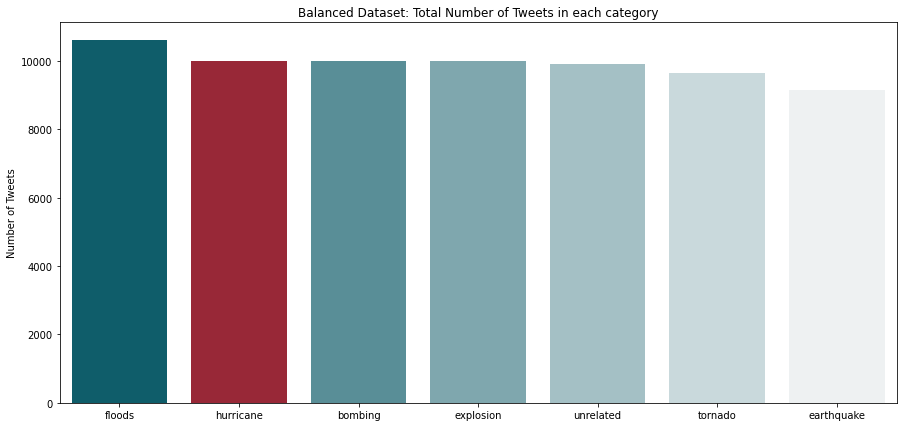

In [23]:
f,ax =plt.subplots(figsize=(15,7))
blues=sns.light_palette((216, 100, 40),dataset_resampled_topics.shape[0], input="husl" ,reverse=True)
blues[1]=sns.color_palette("RdBu", 10)[0]
sns.barplot(x='index',y='label',data=dataset_resampled_topics ,palette=blues, ax=ax)
ax.set_xlabel(' ')
ax.set_ylabel('Number of Tweets')
ax.set_title( 'Balanced Dataset: Total Number of Tweets in each category')

In [24]:
class TextTokenizer(BaseEstimator,TransformerMixin):
    """This is a simple Wrapper class for Keras Tokenizer."""
    def __init__(self,pad_sequences,num_words=10000,max_length=100,max_pad_length=100 ):
        self._num_words=num_words
        self.max_length=max_length
        self._tokenizer=None
        self._pad_sequences=pad_sequences
        self._max_pad_length=max_pad_length
        self.vocab_size=None
        self.tokenizer=None
        
    def transform(self,X,y=None):
        self.tokenizer,self.vocab_size=self._get_tokenizer(X['tweet'])
        X['tweet_encoded']=self.tokenizer.texts_to_sequences(X['tweet'])
        X['tweet_encoded']= X['tweet_encoded'].apply(lambda x: self._pad_sequences([x],maxlen=self._max_pad_length ,padding='post')[0])
        
        return X
    def _get_tokenizer(self,X):
        tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=self._num_words)
        tokenizer.fit_on_texts(X)
        vocab_size=len(tokenizer.word_index)+1
        return tokenizer,vocab_size

In [25]:

tokenization=TextTokenizer(pad_sequences)
dataset_tokenized=tokenization.transform(dataset_resampled)
vocab_size=tokenization.vocab_size
print('Vocab Size:',vocab_size)
dataset_tokenized.head()

Vocab Size: 52714


,tweet,label,label_full,tweet_encoded
0,rt scruffydkm: our prayers are with the famili...,explosion,on-topic_explosion,"[2, 52, 47, 25, 24, 1, 163, 3, 1, 248, 5, 87, ..."
1,rt blairmiller9: kwtx-tv in waco reports 60-70...,explosion,on-topic_explosion,"[2, 1153, 315, 3, 87, 284, 424, 425, 33, 120, ..."
3,rt matthewkeyslive: napa police enforcement co...,earthquake,on-topic_earthquake,"[2, 8467, 131, 136, 1005, 1165, 755, 959, 104,..."
5,rt onurnoyaner: pray for earthquake quake,earthquake,on-topic_earthquake,"[2, 105, 8, 19, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6,i need a nestle buddy done this storm,hurricane,on-topic_hurricane,"[9, 118, 6, 2875, 544, 14, 213, 0, 0, 0, 0, 0,..."


In [26]:
class LabelOneHotEncoder(BaseEstimator,TransformerMixin):
    """Transfroms the Categorical data to One Hot vector"""
    def __init__(self):
        self.label_encoder=None
        self.one_hot_encoder=None
        
    def transform(self,X,y=None):
        self.label_encoder=LabelEncoder().fit(X['label'])
        self.one_hot_encoder=to_categorical
        num_classes=len(set(X['label']))
        X['label_encoded']= self.label_encoder.transform(X['label'].values)
        X['label_one_hot']= X['label_encoded'].apply(lambda x: self.one_hot_encoder([x],num_classes=num_classes)[0])   
        
        return X

In [27]:
encoder=LabelOneHotEncoder()
dataset_encoded=encoder.transform(dataset_resampled)
dataset_encoded.head()

,tweet,label,label_full,tweet_encoded,label_encoded,label_one_hot
0,rt scruffydkm: our prayers are with the famili...,explosion,on-topic_explosion,"[2, 52, 47, 25, 24, 1, 163, 3, 1, 248, 5, 87, ...",2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
1,rt blairmiller9: kwtx-tv in waco reports 60-70...,explosion,on-topic_explosion,"[2, 1153, 315, 3, 87, 284, 424, 425, 33, 120, ...",2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,rt matthewkeyslive: napa police enforcement co...,earthquake,on-topic_earthquake,"[2, 8467, 131, 136, 1005, 1165, 755, 959, 104,...",1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5,rt onurnoyaner: pray for earthquake quake,earthquake,on-topic_earthquake,"[2, 105, 8, 19, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
6,i need a nestle buddy done this storm,hurricane,on-topic_hurricane,"[9, 118, 6, 2875, 544, 14, 213, 0, 0, 0, 0, 0,...",4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"


In [28]:
X_train,X_test,y_train,y_test =train_test_split(dataset_encoded['tweet_encoded'],dataset_encoded['label_one_hot'],test_size=0.3,stratify=dataset_encoded['label_encoded'])
X_train=np.array(X_train.values.tolist())
X_test=np.array(X_test.values.tolist())
y_train=np.array(y_train.values.tolist())
y_test=np.array(y_test.values.tolist())
print('Number of Tweets in Training set: ',X_train.shape[0])
print('Number of Tweets in Test set: ',X_test.shape[0])

Number of Tweets in Training set:  48523
Number of Tweets in Test set:  20796


In [29]:
class PlotLosses(tf.keras.callbacks.Callback):
    """Simple utility function to plot the model losses during training"""
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
plot_losses = PlotLosses() 

def save_model(model,save_name):
    with open(save_name,'w+') as f:
        f.write(model.to_json())
    model.save_weights(save_name+'.h5')

In [30]:
max_length=100
embeding_dim=50
num_classes=y_train[0].shape[0]
model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embeding_dim,input_length=max_length))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.3))
model.add(Dense(10,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'] )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           2635700   
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 77        
Total params: 2,636,287
Trainable params: 2,636,287
Non-trainable params: 0
______________________________________________

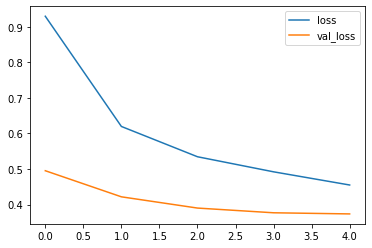

4853/4853 [==============================] - 134s 28ms/step - loss: 0.4550 - accuracy: 0.8519 - val_loss: 0.3737 - val_accuracy: 0.8889


In [31]:
model.fit(X_train,y_train,epochs=5,batch_size=10,verbose=1,validation_data=(X_test,y_test),callbacks=[plot_losses])
save_model(model,'model')

In [32]:
# load json and create model
json_file = open('model', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 88.89%


In [40]:
max_length=100
embeding_dim=50
num_classes=y_train[0].shape[0]
model2=Sequential()
model2.add(Embedding(input_dim=vocab_size,output_dim=embeding_dim,input_length=max_length))
model2.add(Conv1D(128, 5, activation='relu'))
#model2.add(Dropout(0.3))
model2.add(GlobalMaxPool1D())
model2.add(Dropout(0.3))
model2.add(Dense(10,activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(num_classes,activation='softmax'))
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'] )
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           2635700   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           32128     
_________________________________________________________________
dropout_4 (Dropout)          (None, 96, 128)           0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)               

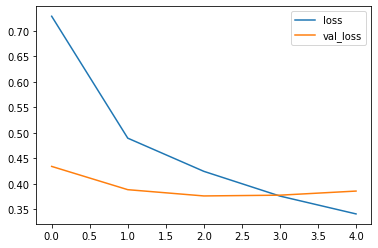

4853/4853 [==============================] - 173s 36ms/step - loss: 0.3413 - accuracy: 0.8888 - val_loss: 0.3860 - val_accuracy: 0.8836


In [41]:
model2.fit(X_train,y_train,epochs=5,batch_size=10,verbose=1,validation_data=(X_test,y_test),callbacks=[plot_losses])
save_model(model2,'model2')

In [35]:
# load json and create model
json_file = open('model2', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model2.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 89.36%




---



---



---



In [42]:
def create_model(dropout, dense_size, vocab_size, embedding_dim, maxlen):
    model=Sequential()
    model.add(Embedding(input_dim=vocab_size,output_dim=embeding_dim,input_length=max_length))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(dropout))
    model.add(Dense(dense_size,activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [43]:
def create_model2(dropout, dense_size, vocab_size, embedding_dim, maxlen, num_filters, kernel_size):
    model=Sequential()
    model.add(Embedding(input_dim=vocab_size,output_dim=embeding_dim,input_length=max_length))
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(dropout))
    model.add(Dense(dense_size,activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model


In [44]:
# Main settings
epochs = 5  #5
embedding_dim = 50  #50
maxlen = 100  # 100
vocab_size=10000  #10000
output_file = 'output.txt'
dense_size=[10, 30, 50,100]

# Parameter grid for grid search
param_grid = dict(dropout=[0.1, 0.2, 0.3, 0.4],
                  dense_size=[10, 30, 50, 100],
                  vocab_size=[vocab_size],
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen],
                  num_filters = [32, 64, 128, 256],
                  kernel_size = [3, 5, 7, 9])

In [ ]:
model = KerasClassifier(build_fn=create_model2,
                        epochs=epochs, batch_size=10,
                        verbose=False)

grid = GridSearchCV(estimator=model, param_grid=param_grid,
                          cv=4, verbose=1 ,n_jobs=8)

grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)
# Save and evaluate results
with open(output_file, 'a') as f:
    s = ('Best Accuracy : '
         '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    output_string = s.format(
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
    print(output_string)
    f.write(output_string)  
print('Done')

Fitting 4 folds for each of 256 candidates, totalling 1024 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 118.1min




---



---



---

